In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

from scipy import optimize

import tensorflow as tf
import torch
import os
os.chdir('..')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib as mpl
from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline, FeatureUnion

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [4]:
from supervised import read_csv, prepare_data, TickerDataSimple

--- log folder exists


In [5]:
X_all, Y = prepare_data('spy', True)
input = pd.DataFrame(X_all.iloc[:, 1:])

# Random sequence data
# train_idx, test_idx = train_test_split(np.arange(len(input)))

# Sequential data
length = int(len(input)* 0.8)
train_idx = np.arange(length)
test_idx = np.arange(length, len(input))

In [6]:
train_df = input.iloc[train_idx]
test_df = input.iloc[test_idx]
print(train_idx.shape, test_idx.shape)
print(train_df.shape, test_df.shape)
# Consider some other y transfroms...
y_train = np.where(Y[train_idx]>0, 1, 0)
y_test = np.where(Y[test_idx]>0, 1, 0)
y_train.sum(), y_test.sum()

(2520,) (631,)
(2520, 24) (631, 24)


(1538, 377)

In [7]:
transfomer = [
    ('Data after standard scaling',
        StandardScaler()),
    ('Data after min-max scaling',
        MinMaxScaler()),
    ('Data after max-abs scaling',
        MaxAbsScaler()),
    ('Data after robust scaling',
        RobustScaler(quantile_range=(25, 75))),
    ('Data after power transformation (Yeo-Johnson)',
     PowerTransformer(method='yeo-johnson')),
    ('Data after quantile transformation (gaussian pdf)',
        QuantileTransformer(output_distribution='normal')),
    ('Data after quantile transformation (uniform pdf)',
        QuantileTransformer(output_distribution='uniform')),
    ('Data after sample-wise L2 normalizing',
        Normalizer()),
]

combined = FeatureUnion(transfomer)
combined_fit = combined.fit(train_df)

In [8]:
x_train_transformed = combined.transform(train_df)
x_test_transformed = combined.transform(test_df)

In [9]:
x_train_transformed.shape, x_test_transformed.shape

((2520, 192), (631, 192))

In [10]:
from functools import reduce

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class AutoEncoder(nn.Module):
    def __init__(self, input_size, final_output_size):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_size,            final_output_size * 8),
            nn.ReLU(True),
            nn.Linear(final_output_size * 8, final_output_size * 4),
            nn.ReLU(True),
            nn.Linear(final_output_size * 4, final_output_size * 2),
            nn.ReLU(True),
            nn.Linear(final_output_size * 2, final_output_size),
            nn.Tanh(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(final_output_size, final_output_size * 2),
            nn.ReLU(True),
            nn.Linear(final_output_size * 2, final_output_size * 4),
            nn.ReLU(True),
            nn.Linear(final_output_size * 4, final_output_size * 8),
            nn.ReLU(True),
            nn.Linear(final_output_size * 8, input_size))

    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)

In [11]:
spy_dataset = TickerDataSimple('spy', x_train_transformed, y_train)

BATCH_SIZE = 64
train_dl = DataLoader(spy_dataset, 
                      num_workers=1, 
                      batch_size=BATCH_SIZE)

spy_testset = TickerDataSimple('spy', x_test_transformed, y_test)

BATCH_SIZE = 64
test_dl = DataLoader(spy_testset, 
                      num_workers=1, 
                      batch_size=BATCH_SIZE)

In [12]:
model = AutoEncoder(192, 8).cuda()
model.load_state_dict(torch.load('linear_auto_encoder.pt'))

In [13]:
from torch.nn.utils import clip_grad_norm_
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=1e-3, weight_decay=1e-6)

lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                    2400, 
                                                    3e-5)

In [14]:
losses = []
num_epochs=200
for epoch in range(num_epochs):
    cur_loss = 0.0
    for data in train_dl:
        x, _ = data
        x = x.cuda()

        output = model(x)
        loss = criterion(output, x)
        
        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        cur_loss += loss.item()
    
    losses += [cur_loss]
    lr_scheduler.step()
    print('\repoch [{}/{}], loss:{:.5f}'
          .format(epoch, num_epochs-1, loss.data.item()), end='')

epoch [199/199], loss:0.00691

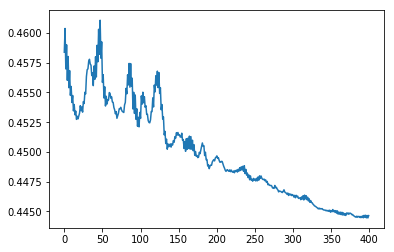

In [163]:
_ = plt.plot(losses)

In [164]:
# torch.save(model.state_dict(), 'linear_auto_encoder.pt')

In [77]:
losses = []
xs = []
outputs = []
for x, y in train_dl:
    x = x.cuda()
    output = model(x)
    xs += [x]
    outputs += [output]
    loss = criterion(output, x)
    losses += [loss.item()]

In [57]:
by_column_loss_mean = torch.zeros((192,))
for idx in range(len(xs)):
    by_column_loss_mean += torch.pow(xs[idx] - outputs[idx], 2
                                    ).mean(0).cpu()

In [69]:
for idx in range(8):
    print((by_column_loss_mean[24*idx: 24*idx+24]).sum().item())

16.460641860961914
0.0870986357331276
0.23172298073768616
19.639759063720703
16.841182708740234
25.550222396850586
3.2899932861328125
3.243394136428833


Looks like 2nd, 3rd, 7th, 8th useful, all others rubbish...?

In [70]:
losses = []
xs = []
outputs = []
for x, y in test_dl:
    x = x.cuda()
    output = model(x)
    xs += [x]
    outputs += [output]
    loss = criterion(output, x)
    losses += [loss.item()]

In [71]:
by_column_loss_mean = torch.zeros((192,))
for idx in range(len(xs)):
    by_column_loss_mean += torch.pow(xs[idx] - outputs[idx], 2
                                    ).mean(0).cpu()

In [72]:
for idx in range(8):
    print((by_column_loss_mean[24*idx: 24*idx+24]).sum().item())

3.013014078140259
0.014550460502505302
0.04097181186079979
3.6275320053100586
3.0430538654327393
4.267138481140137
0.5650008320808411
1.1323521137237549


Indeed...

Time for a simple regression

In [105]:
class LogisticRegressor(nn.Module):
    def __init__(self, input_size, final_output_size):
        super(LogisticRegressor, self).__init__()

        self.l1 = nn.Linear(input_size, 24)
        self.l2 = nn.Linear(24, 12)
        self.l3 = nn.Linear(12, 6)
        self.l4 = nn.Linear(6, 1)

        self.d1 = nn.Dropout(inplace=True)
        self.d2 = nn.Dropout(inplace=True)
        
    def forward(self, x):
        x = torch.relu(self.l1(x))
        x = torch.relu(self.l2(x))
        x = self.d1(x)
        x = torch.relu(self.l3(x))
        x = self.d2(x)
        return torch.sigmoid(self.l4(x))

In [112]:
# Keep 2nd, 3rd, 7th, 8th
transfomer = [
    ('Data after min-max scaling',
        MinMaxScaler()),
    ('Data after max-abs scaling',
        MaxAbsScaler()),
    ('Data after quantile transformation (uniform pdf)',
        QuantileTransformer(output_distribution='uniform')),
    ('Data after sample-wise L2 normalizing',
        Normalizer()),
]

combined = FeatureUnion(transfomer)
combined_fit = combined.fit(train_df)

/home/wbaik/.conda/envs/clone_tf/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [111]:
x_train_transformed = combined.transform(train_df)
x_test_transformed = combined.transform(test_df)

spy_dataset = TickerData('spy', x_train_transformed, y_train)

BATCH_SIZE = 64
train_dl = DataLoader(spy_dataset, 
                      num_workers=1, 
                      batch_size=BATCH_SIZE)

spy_testset = TickerData('spy', x_test_transformed, y_test)

BATCH_SIZE = 64
test_dl = DataLoader(spy_testset, 
                      num_workers=1, 
                      batch_size=BATCH_SIZE)

In [114]:
# Each Data Points are 24 (6 * 4)
# Transformer has 4 different ways
model = LogisticRegressor(24 * 4, 1).cuda()

In [117]:
from torch.nn.utils import clip_grad_norm_
import torch.optim as optim

criterion = nn.modules.loss.BCELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=1e-3, weight_decay=1e-6)

lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                    2400, 
                                                    3e-5)

In [245]:
losses = []
num_epochs=10
for epoch in range(num_epochs):
    cur_loss = []
    
    for x, y in train_dl:
        x = x.cuda()
        y = y.cuda()

        output = model(x).squeeze()
        loss = criterion(output, y)
        
        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        cur_loss += [loss.item()]
    
    losses += [np.mean(cur_loss)]
    lr_scheduler.step()
    print('\repoch [{}/{}], loss:{:.5f}'
          .format(epoch, num_epochs-1, np.mean(cur_loss)), end='')

epoch [9/9], loss:0.51706

In [250]:
criterion(output, y)

tensor(0.1380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

### Overfit way too fast...

In [232]:
losses = []
num_epochs=10
for epoch in range(num_epochs):
    cur_loss = []
    
    for x, y in test_dl:
        x = x.cuda()
        y = y.cuda()

        output = model(x).squeeze()
        loss = criterion(output, y)
        
        cur_loss += [loss.item()]
    
    losses += [np.mean(cur_loss)]
    print('\repoch [{}/{}], loss:{:.5f}'
          .format(epoch, num_epochs-1, np.mean(cur_loss)), end='')

epoch [9/9], loss:2.85185

In [233]:
losses

[3.0512255311012266,
 2.8766530632972716,
 2.86578289270401,
 2.5856173396110536,
 2.707858508825302,
 2.848202592134476,
 2.694500195980072,
 2.694444751739502,
 2.8524972796440125,
 2.8518472731113436]